## Emergency Department Triage Data ⚕️

The ED (emergency department) is a hospital or primary health care service that provides initial treatment to patients with a broad spectrum of illnesses and injuries, some of which may be life-threatening and require immediate attention. EDs provide rapid assessment and management of critical illnesses. After initial assessment and treatment, patients are either admitted to the hospital, stabilised and transferred to another hospital for various reasons, or discharged (Australasian College of Emergency Medicine).Upon arrival in the ED, people usually undergo a brief triage, or interview, to help determine the nature and severity of their illness. Individuals with serious illnesses are then seen by a physician more rapidly than those with less severe symptoms or injuries. The data includes patient attendances, admissions and admissions by Triage for 1 June 2013 to 30 June 2014.

Definitions:
- Attendances - the number of patients recorded as arriving at a public emergency department. 
- Admissions - the number of patients who are subsequently admitted to the hospital for care and/or treatment.

Triage:
- Triage 1: Resuscitation- immediate, within seconds
- Triage 2: Emergency- within 10 minutes
- Triage 3: Urgent- within 30 minutes
- Triage 4: Semi-urgent- within 60 minutes
- Triage 5: Non-urgent - within 120 minutes. 
- N/A - Values is less than 3 and has been suppressed.

Note: The data is for the last 6 months of 2013 and first 6 months of 2014

##### Load python packages

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from pmdarima import auto_arima

##### Upload data

In [2]:
data = pd.read_csv(r'C:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\govhack3.csv', sep=',', header=1)
data.shape

(365, 64)

##### Clean data

In [3]:
# Change N/A in column Tri.5.8 to Null
data['Tri_5.8'] = data['Tri_5.8'].replace('N/A', np.nan)

# Remove commas and convert to numeric, forcing errors to NaN
data['Tri_5.8'] = pd.to_numeric(data['Tri_5.8'].str.replace(',', ''), errors='coerce')

##### Statical summary of data

In [4]:
# statistical summary of the data
data.describe()

,Attendance,Admissions,Tri_1,Tri_2,Tri_3,Tri_4,Tri_5,Attendance.1,Admissions.1,Tri_1.1,...,Tri_3.7,Tri_4.7,Tri_5.7,Attendance.8,Admissions.8,Tri_1.8,Tri_2.8,Tri_3.8,Tri_4.8,Tri_5.8
count,365.000000,365.000000,285.000000,365.000000,365.000000,365.000000,364.000000,365.000000,365.000000,78.000000,...,365.000000,365.000000,302.000000,365.000000,365.000000,43.000000,365.000000,365.000000,365.000000,319.000000
mean,227.019178,96.235616,5.045614,35.646575,81.200000,89.446575,16.250000,158.868493,65.216438,3.435897,...,49.709589,71.421918,6.996689,256.810959,73.304110,3.534884,30.583562,90.838356,126.934247,8.031348
std,17.276585,12.514139,2.012642,7.346489,11.389025,14.234130,6.510058,14.617249,8.069053,0.731299,...,9.060726,11.042006,3.910543,22.059233,8.239753,0.908920,5.973545,13.619583,18.440014,4.508443
min,179.000000,37.000000,3.000000,12.000000,48.000000,53.000000,4.000000,118.000000,43.000000,3.000000,...,26.000000,42.000000,3.000000,201.000000,51.000000,3.000000,16.000000,59.000000,75.000000,3.000000
25%,215.000000,88.000000,3.000000,30.000000,73.000000,80.000000,11.000000,148.000000,59.000000,3.000000,...,44.000000,64.000000,4.000000,241.000000,68.000000,3.000000,27.000000,81.000000,116.000000,5.000000
50%,227.000000,96.000000,5.000000,35.000000,80.000000,88.000000,16.000000,159.000000,65.000000,3.000000,...,49.000000,71.000000,6.000000,254.000000,73.000000,3.000000,30.000000,90.000000,127.000000,7.000000
75%,239.000000,105.000000,6.000000,40.000000,88.000000,101.000000,20.000000,169.000000,71.000000,4.000000,...,56.000000,79.000000,9.000000,271.000000,79.000000,4.000000,35.000000,100.000000,138.000000,10.500000
max,275.000000,131.000000,15.000000,59.000000,113.000000,129.000000,37.000000,198.000000,89.000000,7.000000,...,80.000000,99.000000,27.000000,323.000000,96.000000,7.000000,50.000000,124.000000,182.000000,31.000000


##### Reformat data

In [5]:
# Get list of hospitals
data2 = pd.read_csv(r'C:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\govhack3.csv', sep=',', header=None)
hospitals = []
first_row = data2.iloc[[0]]
hospitals = first_row.dropna(axis=1).values.flatten().tolist()

In [6]:
# Create empty dataframe named 'hospital_df' containing the first and the last 8 column names of the data dataframe
hospital_df = pd.DataFrame(columns=['Date', 'Hospital', 'Attendance', 'Admissions', 'Tri_1', 'Tri_2', 'Tri_3', 'Tri_4', 'Tri_5'])

for i in range(len(hospitals)):
    hospital_name = hospitals[-(i+1)]  # Get the hospital name from the list
    print(hospital_name)
    
    # Insert the hospital name into a new column
    data.insert(len(data.columns)-7, 'hospital', hospital_name)
    
    # Save the first and the last 8 columns to a new DataFrame
    new_df = data.iloc[:, [0, -8, -7, -6, -5, -4, -3, -2, -1]]

    # Rename the columns
    new_df.columns = ['Date', 'Hospital', 'Attendance', 'Admissions', 'Triage 1', 'Triage 2', 'Triage 3', 'Triage 4', 'Triage 5']

    # Join new_df to hospital_df
    hospital_df = pd.concat([hospital_df, new_df])
    
    # Delete the last 8 columns from the original DataFrame
    data = data.iloc[:, :-8]


Joondalup Health Campus
Rockingham General Hospital
Swan District Hospital
Armadale/Kelmscott District Memorial Hospital
Sir Charles Gairdner Hospital
King Edward Memorial Hospital For Women
Princess Margaret Hospital For Children
Fremantle Hospital
Royal Perth Hospital


In [7]:
# Plot (Plotly boxplot showing  all data points) the distribution of each triage category for each year for each hospital. Two separate plots for each triage category.

# Ensure all triage columns are numeric
triage_columns = ['Triage 1']
hospital_df[triage_columns] = hospital_df[triage_columns].apply(pd.to_numeric, errors='coerce')

# Define a function to create and update vertical box plots
def create_vertical_box_plot(df, y_cols, X_title, plot_height, plot_width):
    fig = px.box(df, y=y_cols, color='Hospital', points="all")
    fig.update_layout(
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
        height=fig.layout.height / 2 if fig.layout.height else plot_height,
        width=fig.layout.width * 6 if fig.layout.width else plot_width,
        yaxis_title='Count',
        xaxis_title=X_title,
        template='plotly_white'
    )
    fig.update_traces(marker=dict(size=2, opacity=0.6), line=dict(width=1))
    fig.update_traces(jitter=0.2, pointpos=-1.8)
    fig.show()

# Create vertical box plot for Triage 1
create_vertical_box_plot(hospital_df, 'Triage 1', 'Triage 1', 500, 700)


In [8]:
# plotly bar plot of the total number of triage 1 patients for each hospital.
# Calculate the total number of Triage 1 patients for each hospital
total_triage_1 = hospital_df.groupby('Hospital')['Triage 1'].sum().reset_index()

# Create a bar plot
fig = px.bar(total_triage_1, 
             x='Hospital', 
             y='Triage 1', 
             text='Triage 1', 
             title='Total number of Triage 1 patients for each hospital')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', 
                  height=fig.layout.height if fig.layout.height else 600, 
                  width=fig.layout.width / 2 if fig.layout.width else 1200, 
                  yaxis_title='Count', 
                  legend_title='Category',
                  yaxis_range=[0,1600],
                  xaxis=dict(tickfont=dict(size=2*(fig.layout.xaxis.tickfont.size if fig.layout.xaxis.tickfont.size else 10))))
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.show()

In [9]:
# Plot (Plotly boxplot showing  all data points) the distribution of each triage category for each year for each hospital. Two separate plots for each triage category.

# Ensure all triage columns are numeric
triage_columns = ['Triage 2', 'Triage 5']
hospital_df[triage_columns] = hospital_df[triage_columns].apply(pd.to_numeric, errors='coerce')
    
# Create a combined vertical box plot for all triage categories
create_vertical_box_plot(hospital_df, ['Triage 2', 'Triage 5'], 'Triage Categories', 600, 800)


In [10]:
# Plot (Plotly boxplot showing  all data points) the distribution of each triage category for each year for each hospital. Two separate plots for each triage category.

# Ensure all triage columns are numeric
triage_columns = ['Triage 3', 'Triage 4']
hospital_df[triage_columns] = hospital_df[triage_columns].apply(pd.to_numeric, errors='coerce')
    
# Create a combined vertical box plot for all triage categories
create_vertical_box_plot(hospital_df, ['Triage 3', 'Triage 4'], 'Triage Categories', 600, 800)

In [11]:
# Plot (Plotly kernel density extimation plots) the distribution of each triage category for each year for each hospital.

# Define a function to create and update kernel density estimation plots
def create_kde_plot(df, y_cols, X_title):
    fig = ff.create_distplot([df[col].dropna() for col in y_cols], y_cols, show_hist=False, show_rug=False)
    # fig.update_layout(
    #     legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
    #     height=fig.layout.height / 2 if fig.layout.height else 600,
    #     width=fig.layout.width * 6 if fig.layout.width else 1800,
    #     yaxis_title='Density',
    #     xaxis_title=X_title,
    #     template='plotly_white'
    # )
    fig.show()

create_kde_plot(hospital_df, ['Triage 2', 'Triage 3', 'Triage 4', 'Triage 5'], 'Triage Categories')


In [12]:
# Function to count null values for each hospital
def count_nulls(df, group_col, *columns):
	return df.groupby(group_col)[list(columns)].apply(lambda x: x.isnull().sum()).reset_index()

# Calculate the number of nulls for each triage column. Output as a table or graph showing each hospital
nulls = count_nulls(hospital_df, 'Hospital', 'Attendance', 'Admissions', 'Triage 1', 'Triage 2', 'Triage 3', 'Triage 4', 'Triage 5')

# Display the nulls dataframe
# Display as a table
nulls.round(1).style.set_table_styles([{'selector': 'thead', 'props': 'color: black; background: white;'}]).set_caption('Total Nulls')



,Hospital,Attendance,Admissions,Triage 1,Triage 2,Triage 3,Triage 4,Triage 5
0,Armadale/Kelmscott District Memorial Hospital,0,0,343,0,0,0,13
1,Fremantle Hospital,0,0,287,0,0,0,0
2,Joondalup Health Campus,0,0,322,0,0,0,46
3,King Edward Memorial Hospital For Women,0,86,365,364,85,0,3
4,Princess Margaret Hospital For Children,0,0,342,7,0,0,179
5,Rockingham General Hospital,0,1,355,0,0,0,63
6,Royal Perth Hospital,0,0,80,0,0,0,1
7,Sir Charles Gairdner Hospital,0,0,175,0,0,0,110
8,Swan District Hospital,0,0,331,0,0,0,33


### Summary of Null Values in Hospital Triage Dataset

- **Common Null Columns**: 
  - The column **"Tri_1"** has the highest frequency of null values across hospitals, with counts ranging from 80 to 365 nulls per hospital.

- **Hospital-Specific Patterns**:
  - **King Edward Memorial Hospital for Women**: 
    - High null counts in multiple columns, especially in "Tri_1" (365), "Tri_2" (364), and "Tri_3" (85).
  - **Princess Margaret Hospital for Children**: 
    - 342 nulls in "Tri_1" and a notable 179 nulls in "Tri_5."
  - **Sir Charles Gairdner Hospital**: 
    - 175 nulls in "Tri_1" and 110 nulls in "Tri_5."

- **Low or No Null Counts**:
  - Columns **"Attendance"** and **"Tri_2"** generally have zero null values across most hospitals.

- **Admissions Null Values**:
  - **King Edward Memorial Hospital for Women** has a high count of 86 nulls in "Admissions," whereas other hospitals have very few or no nulls in this column.

---


##### Calculate totals for admissions, attendances and triage

In [13]:
# Group by 'Hospital' and sum the specified columns, output as numbers
def group_and_sum(hospital_df, columns):
    return hospital_df.groupby('Hospital')[columns].sum().reset_index()

# List of columns to sum
columns_to_sum = ['Attendance', 'Admissions', 'Triage 1', 'Triage 2', 'Triage 3', 'Triage 4', 'Triage 5']

# Generate totals for all specified columns
totals = group_and_sum(hospital_df, columns_to_sum)

# Convert all numerical columns to int
for col in totals.columns[1:]:
    totals[col] = totals[col].astype(int)

# Assign the final dataframe to total_df
total_df = totals

# Display the total_df with scroll bars and add a header
total_df.round(1).style.set_table_styles([{'selector': 'thead', 'props': 'color: black; background: white;'}]).set_caption('Total Admissions, Attendances and Triage Numbers by Hospital (2013-2014)')


,Hospital,Attendance,Admissions,Triage 1,Triage 2,Triage 3,Triage 4,Triage 5
0,Armadale/Kelmscott District Memorial Hospital,61504,7594,69,8144,23480,25513,4044
1,Fremantle Hospital,57987,23804,268,10128,21045,20618,5614
2,Joondalup Health Campus,93736,26756,152,11163,33156,46331,2562
3,King Edward Memorial Hospital For Women,14439,1370,0,3,1407,7287,5512
4,Princess Margaret Hospital For Children,71119,12225,80,2881,17982,48901,777
5,Rockingham General Hospital,52803,5783,32,6136,18144,26069,2113
6,Royal Perth Hospital,82862,35126,1438,13011,29638,32648,5915
7,Sir Charles Gairdner Hospital,65871,39400,783,15716,30675,16924,1393
8,Swan District Hospital,47347,8993,109,8033,18154,18011,2711


##### Plot of total Admissions and Attendances for each Hospital

In [14]:
# Plot of hospital admissions and attendance
columns = ['Attendance', 'Admissions']

fig = px.bar(total_df, 
             x='Hospital', 
             y=columns, 
             title='Total Attendance and Admissions by Hospital',
             labels={'value': 'Count', 'variable': 'Category'},
             barmode='group')

fig.update_layout(xaxis_title='Hospital', 
                  yaxis_title='Count', 
                  legend_title='Category',
                  legend=dict(orientation="h", 
                              yanchor="bottom", 
                              y=1.02, 
                              xanchor="center", 
                              x=0.5))

fig.show()

In [15]:
# Plot of hospital admissions for each day of the week
# Create a new column with the day of the week
hospital_df['Date'] = pd.to_datetime(hospital_df['Date'])
hospital_df['Day of Week'] = hospital_df['Date'].dt.day_name()

# Set the order of the days of the week
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hospital_df['Day of Week'] = pd.Categorical(hospital_df['Day of Week'], categories=days_order, ordered=True)

# Group by 'Hospital' and 'Day of Week' and sum the 'Admissions' column
admissions_by_day = hospital_df.groupby(['Hospital', 'Day of Week'])['Admissions'].sum().reset_index()

# Plot the admissions by day of the week
fig = px.bar(admissions_by_day, 
             x='Hospital', 
             y='Admissions', 
             color='Day of Week', 
             title='Admissions by Day of the Week',
             labels={'Admissions': 'Count'},
             barmode='group')

fig.update_layout(xaxis_title='Hospital',
                  yaxis_title='Count',
                  legend_title='Day of Week',
                  legend=dict(orientation="h", 
                              yanchor="bottom", 
                              y=1.02, 
                              xanchor="center", 
                              x=0.5))

fig.show()

C:\Users\guino\AppData\Local\Temp\ipykernel_32384\362099085.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\guino\AppData\Local\Temp\ipykernel_32384\362099085.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [16]:
# Plot of hospital attendances for each day of the week
# Create a new column with the day of the week
hospital_df['Date'] = pd.to_datetime(hospital_df['Date'])
hospital_df['Day of Week'] = hospital_df['Date'].dt.day_name()

# Set the order of the days of the week
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hospital_df['Day of Week'] = pd.Categorical(hospital_df['Day of Week'], categories=days_order, ordered=True)

# Group by 'Hospital' and 'Day of Week' and sum the 'Admissions' column
attendance_by_day = hospital_df.groupby(['Hospital', 'Day of Week'])['Attendance'].sum().reset_index()

# Plot the admissions by day of the week
fig = px.bar(attendance_by_day, 
             x='Hospital', 
             y='Attendance', 
             color='Day of Week', 
             title='Attendances by Day of the Week',
             labels={'Attendances': 'Count'},
             barmode='group')

fig.update_layout(xaxis_title='Hospital',
                  yaxis_title='Count',
                  legend_title='Day of Week',
                  legend=dict(orientation="h", 
                              yanchor="bottom", 
                              y=1.02, 
                              xanchor="center", 
                              x=0.5))

fig.show()

C:\Users\guino\AppData\Local\Temp\ipykernel_32384\4264671920.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [17]:
# Plot of hospital triage 1 for each day of the week. Repeat for triage 2, 3, 4 and 5. Place plot one under the other
# Create a new column with the day of the week
hospital_df['Date'] = pd.to_datetime(hospital_df['Date'])
hospital_df['Day of Week'] = hospital_df['Date'].dt.day_name()

# Set the order of the days of the week
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hospital_df['Day of Week'] = pd.Categorical(hospital_df['Day of Week'], categories=days_order, ordered=True)

# Function to plot triage data by day of the week
def plot_triage_by_day(triage_column):
    triage_by_day = hospital_df.groupby(['Hospital', 'Day of Week'])[triage_column].sum().reset_index()
    fig = px.bar(triage_by_day, 
                 x='Hospital', 
                 y=triage_column, 
                 color='Day of Week', 
                 title=f'{triage_column} by Day of the Week',
                 labels={triage_column: 'Count'},
                 barmode='group')
    fig.update_layout(xaxis_title='Hospital',
                      yaxis_title='Count',
                      legend_title='Day of Week',
                      legend=dict(orientation="h", 
                                  yanchor="bottom", 
                                  y=1.02, 
                                  xanchor="center", 
                                  x=0.5))
    fig.show()

# Plot triage data for each triage level
for triage in ['Triage 1', 'Triage 2', 'Triage 3', 'Triage 4', 'Triage 5']:
    plot_triage_by_day(triage)



C:\Users\guino\AppData\Local\Temp\ipykernel_32384\2796886400.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\guino\AppData\Local\Temp\ipykernel_32384\2796886400.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\guino\AppData\Local\Temp\ipykernel_32384\2796886400.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\guino\AppData\Local\Temp\ipykernel_32384\2796886400.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\guino\AppData\Local\Temp\ipykernel_32384\2796886400.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



##### Plot of totals for each triage category for each hospital

In [18]:
# Plot of number of triaged patients by hospital
columns = ['Triage 1', 'Triage 2', 'Triage 3', 'Triage 4', 'Triage 5']


fig = px.bar(total_df, 
             x='Hospital', 
             y=columns, 
             title='Total Triage Counts by Hospital',
             labels={'value': 'Count', 'variable': 'Category'},
             barmode='group')

fig.update_layout(xaxis_title='Hospital', 
                  yaxis_title='Count', 
                  legend_title='Category',
                  legend=dict(orientation="h", 
                              yanchor="bottom", 
                              y=1.02, 
                              xanchor="center", 
                              x=0.5))

fig.show()

##### Calculation of percentage of Attendances for each triage category

In [19]:
# Percentage Attendances that are Triaged at different Levels for Each Hospital

# Convert triage data to percentage of the number of attendances
tri_columns = ['Triage 1', 'Triage 2', 'Triage 3', 'Triage 4', 'Triage 5']

# Create a copy of the total_df
percent_df = total_df.copy()

# Calculate the percentage of triage patients for each triage category
for col in tri_columns:
    percent_df[col] = ((percent_df[col] / percent_df['Attendance']) * 100)

# Print the table
percent_df.style.set_table_styles([{'selector': 'thead', 'props': 'color: black; background: white;'}]).set_caption('Percentage Attendances that are Triaged at different Levels for Each Hospital')

,Hospital,Attendance,Admissions,Triage 1,Triage 2,Triage 3,Triage 4,Triage 5
0,Armadale/Kelmscott District Memorial Hospital,61504,7594,0.112188,13.241415,38.176379,41.481855,6.575182
1,Fremantle Hospital,57987,23804,0.462173,17.465984,36.292617,35.556245,9.681480
2,Joondalup Health Campus,93736,26756,0.162158,11.908978,35.371682,49.427114,2.733208
3,King Edward Memorial Hospital For Women,14439,1370,0.000000,0.020777,9.744442,50.467484,38.174389
4,Princess Margaret Hospital For Children,71119,12225,0.112488,4.050957,25.284383,68.759403,1.092535
5,Rockingham General Hospital,52803,5783,0.060603,11.620552,34.361684,49.370301,4.001667
6,Royal Perth Hospital,82862,35126,1.735416,15.702011,35.767903,39.400449,7.138375
7,Sir Charles Gairdner Hospital,65871,39400,1.188687,23.858754,46.568293,25.692642,2.114739
8,Swan District Hospital,47347,8993,0.230215,16.966228,38.342450,38.040425,5.725812


##### Calculate the number triaged per year for each hospital

In [20]:
# Extract the year from the 'Date' column and add it to the dataframe
hospital_df['Year'] = hospital_df['Date'].apply(lambda x: pd.to_datetime(x).year)

# Group by 'Hospital' and 'Year', and sum the specified columns, output as numbers
def group_and_sum(hospital_df, columns):
    return hospital_df.groupby(['Hospital', 'Year'])[columns].sum().reset_index()

# List of columns to sum
columns_to_sum = ['Attendance', 'Admissions', 'Triage 1', 'Triage 2', 'Triage 3', 'Triage 4', 'Triage 5']

# Generate totals for all specified columns
totals = group_and_sum(hospital_df, columns_to_sum)

# Convert all numerical columns to int
for col in totals.columns[2:]:
    totals[col] = totals[col].astype(int)

# Assign the final dataframe to total_df
total_df = totals

# Display the total_df with scroll bars and add a header
total_df.round(1).style.set_table_styles([{'selector': 'thead', 'props': 'color: black; background: white;'}]).set_caption('Total Admissions, Attendances and Triage Numbers by Hospital and Year')

,Hospital,Year,Attendance,Admissions,Triage 1,Triage 2,Triage 3,Triage 4,Triage 5
0,Armadale/Kelmscott District Memorial Hospital,2013,31275,3879,33,4128,11904,13199,1880
1,Armadale/Kelmscott District Memorial Hospital,2014,30229,3715,36,4016,11576,12314,2164
2,Fremantle Hospital,2013,28902,11613,149,4981,10520,10327,2774
3,Fremantle Hospital,2014,29085,12191,119,5147,10525,10291,2840
4,Joondalup Health Campus,2013,46352,13281,70,5697,16849,22385,1160
5,Joondalup Health Campus,2014,47384,13475,82,5466,16307,23946,1402
6,King Edward Memorial Hospital For Women,2013,7263,673,0,0,699,3694,2770
7,King Edward Memorial Hospital For Women,2014,7176,697,0,3,708,3593,2742
8,Princess Margaret Hospital For Children,2013,36718,6188,46,1512,9416,25076,394
9,Princess Margaret Hospital For Children,2014,34401,6037,34,1369,8566,23825,383


##### Percentage Attendances that are Triaged at different Levels for Each Hospital per year

In [21]:
# Percentage Attendances that are Triaged at different Levels for Each Hospital per year

# Convert triage data to percentage of the number of attendances
tri_columns = ['Triage 1', 'Triage 2', 'Triage 3', 'Triage 4', 'Triage 5']

# Create a copy of the total_df
percent_df = total_df.copy()

# Calculate the percentage of triage patients for each triage category
for col in tri_columns:
    percent_df[col] = ((percent_df[col] / percent_df['Attendance']) * 100)

# Print the table
percent_df.style.set_table_styles([{'selector': 'thead', 'props': 'color: black; background: white;'}]).set_caption('Percentage Attendances that are Triaged at different Levels for Each Hospital per Year')


,Hospital,Year,Attendance,Admissions,Triage 1,Triage 2,Triage 3,Triage 4,Triage 5
0,Armadale/Kelmscott District Memorial Hospital,2013,31275,3879,0.105516,13.199041,38.062350,42.203038,6.011191
1,Armadale/Kelmscott District Memorial Hospital,2014,30229,3715,0.119091,13.285256,38.294353,40.735717,7.158689
2,Fremantle Hospital,2013,28902,11613,0.515535,17.234101,36.398865,35.731091,9.597952
3,Fremantle Hospital,2014,29085,12191,0.409146,17.696407,36.187038,35.382500,9.764483
4,Joondalup Health Campus,2013,46352,13281,0.151018,12.290732,36.350104,48.293493,2.502589
5,Joondalup Health Campus,2014,47384,13475,0.173054,11.535539,34.414570,50.536046,2.958805
6,King Edward Memorial Hospital For Women,2013,7263,673,0.000000,0.000000,9.624122,50.860526,38.138510
7,King Edward Memorial Hospital For Women,2014,7176,697,0.000000,0.041806,9.866221,50.069677,38.210702
8,Princess Margaret Hospital For Children,2013,36718,6188,0.125279,4.117871,25.644098,68.293480,1.073043
9,Princess Margaret Hospital For Children,2014,34401,6037,0.098834,3.979535,24.900439,69.256708,1.113340


#### Difference in total between 2013 and 2014

In [22]:
# Calculate the difference in the number of triaged patients for each category between 2013 and 2014
tri_columns = ['Triage 1', 'Triage 2', 'Triage 3', 'Triage 4', 'Triage 5']
triage_diff = total_df.pivot(index='Hospital', columns='Year', values=tri_columns)
triage_diff['Tri_1_diff'] = triage_diff['Triage 1'][2014] - triage_diff['Triage 1'][2013]
triage_diff['Tri_2_diff'] = triage_diff['Triage 2'][2014] - triage_diff['Triage 2'][2013]
triage_diff['Tri_3_diff'] = triage_diff['Triage 3'][2014] - triage_diff['Triage 3'][2013]
triage_diff['Tri_4_diff'] = triage_diff['Triage 4'][2014] - triage_diff['Triage 4'][2013]
triage_diff['Tri_5_diff'] = triage_diff['Triage 5'][2014] - triage_diff['Triage 5'][2013]

# Select only the difference columns
triage_diff = triage_diff[['Tri_1_diff', 'Tri_2_diff', 'Tri_3_diff', 'Tri_4_diff', 'Tri_5_diff']]

# Display the table
triage_diff.round(1).style.set_table_styles([{'selector': 'thead', 'props': 'color: black; background: white;'}]).set_caption('Difference in the Number of Triage Patients for Each Category between 2013 and 2014')

,Tri_1_diff,Tri_2_diff,Tri_3_diff,Tri_4_diff,Tri_5_diff
Year,,,,,
Hospital,,,,,
Armadale/Kelmscott District Memorial Hospital,3,-112,-328,-885,284
Fremantle Hospital,-30,166,5,-36,66
Joondalup Health Campus,12,-231,-542,1561,242
King Edward Memorial Hospital For Women,0,3,9,-101,-28
Princess Margaret Hospital For Children,-12,-143,-850,-1251,-11
Rockingham General Hospital,-6,-314,-818,-35,205
Royal Perth Hospital,18,-7,148,-358,351
Sir Charles Gairdner Hospital,-131,226,-291,314,59


In [23]:
# Create a plotly chart of the data
fig = px.line(hospital_df, 
              x='Date', 
              y='Admissions', 
              color='Hospital', 
              title='Hospital Admissions')

fig.update_layout(legend=dict(orientation="h", 
                              yanchor="bottom", 
                              y=-0.3, 
                              xanchor="center", 
                              x=0.5))

# Set a default height if it is None
if fig.layout.height is None:
    fig.layout.height = 600  # Set a default height value

fig.show()

In [24]:
# Create a plotly chart of the data
fig = px.line(hospital_df.dropna(subset=['Triage 1']), 
              x='Date', 
              y='Triage 1', 
              color='Hospital', 
              title='Hospital Triage 1')

fig.update_layout(legend=dict(orientation="h", 
                              yanchor="bottom", 
                              y=-0.3, 
                              xanchor="center", 
                              x=0.5))

# Set a default height if it is None
if fig.layout.height is None:
    fig.layout.height = 600  # Set a default height value

fig.show()

In [25]:
# Create a plotly histogram plot for triage 1 at the Royal Perth Hospital
# Filter the data for the Royal Perth Hospital
royal_perth = hospital_df[hospital_df['Hospital'] == 'Royal Perth Hospital']

# Create a histogram plot
fig = px.histogram(royal_perth, 
                   x='Triage 1', 
                   title='Triage 1 at the Royal Perth Hospital', 
                   nbins=20)

fig.update_layout(xaxis_title='Triage 1',
                    yaxis_title='Count')

# Set a default width if it is None
if fig.layout.width is None:
    fig.layout.width = 600  # Set a default height value

# Add black outline to bars
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

fig.show()



The data for triage 1 patients at the Royal Perth Hospital is left skewed

In [26]:
# plotly time series line plot of triage 1 data for the Royal Perth Hospital
# Filter the data for the Royal Perth Hospital
royal_perth = hospital_df[hospital_df['Hospital'] == 'Royal Perth Hospital']

# Create a time series line plot, ignoring missing values
fig = px.line(royal_perth.dropna(subset=['Triage 1']), 
              x='Date', 
              y='Triage 1', 
              title='Triage 1 at the Royal Perth Hospital')

fig.update_layout(legend=dict(orientation="h",
                                yanchor="bottom",
                                y=-0.3,
                                xanchor="center",
                                x=0.5))

# Set a default height if it is None
if fig.layout.height is None:
    fig.layout.height = 600  # Set a default height value

fig.show()

See spikes in triage 1 admissions on:
- July 28, 2013 – Saturday
- August 31, 2013 – Saturday
- December 8, 2013 – Sunday
- December 14, 2013 – Saturday
- January 1, 2014 – Wednesday
- February 5, 2014 – Wednesday
- February 13, 2014 – Thursday
- March 7, 2014 – Friday
- March 21, 2014 – Friday
- April 23, 2014 – Wednesday
- June 9, 2014 – Monday
- June 14, 2014 – Saturday
- July 29, 2014 – Tuesday

In [27]:
# Compare 7 and 14-day time series line plot of 3-day rolling average plots of triage 1 data starting for the Royal Perth Hospital.
# Filter the trage 1 data for the Royal Perth Hospital
royal_perth_triage_1 = royal_perth[['Date', 'Triage 1']].dropna(subset=['Triage 1'])

# Calculate the 7-day rolling average
royal_perth_triage_1['7-day rolling average'] = royal_perth_triage_1['Triage 1'].rolling(window=7).mean()

# Calculate the 30-day rolling average
royal_perth_triage_1['14-day rolling average'] = royal_perth_triage_1['Triage 1'].rolling(window=14).mean()

# Create a time series line plot for the original data and the rolling averages
fig = px.line(royal_perth_triage_1, 
              x='Date', 
              y=['Triage 1', '7-day rolling average', '14-day rolling average'], 
              title='Triage 1 and Rolling Averages at the Royal Perth Hospital')

# Update the layout to highlight the moving averages
fig.update_traces(line=dict(width=2))
fig.update_traces(selector=dict(name='Triage 1'), line=dict(color='blue', width=2, dash='solid'), opacity=0.2)
fig.update_traces(selector=dict(name='7-day rolling average'), line=dict(color='red', width=3))
fig.update_traces(selector=dict(name='14-day rolling average'), line=dict(color='purple', width=3))


fig.update_layout(legend=dict(orientation="h",
                                yanchor="bottom",
                                y=-0.3,
                                xanchor="center",
                                x=0.5))

# Set a default height if it is None
if fig.layout.height is None:
    fig.layout.height = 1200  # Set a default height value

fig.show()




The 7 and 14-day rolling averages suggest some cyclic (possibly seaonal) nature to the data with peaks seen in Sept, Nov, Dec and May.

In Perth, Australia, where the seasons are reversed compared to the Northern Hemisphere, the increases in triage 1 (urgent care needed) patients during September, November, December, and May could be driven by a combination of seasonal factors, weather patterns, and sociocultural influences that are specific to the Southern Hemisphere. Here's a breakdown of potential reasons for these patterns in each of those months:

1. **September (Spring Begins):** 
- **Allergy Season:** As Perth transitions from winter to spring, pollen levels typically rise, leading to more respiratory issues like asthma exacerbations, hay fever, and allergic reactions. People with pre-existing conditions may experience worsened symptoms, requiring urgent care.
- **Increased Respiratory Infections:** While it’s technically spring, there can still be some lingering cooler weather, which can contribute to an uptick in colds and respiratory infections. Hospitals may see more cases of bronchitis, pneumonia, and flu-like symptoms.
- **Outdoor Activity Injuries:** As the weather becomes milder, people are more likely to engage in outdoor activities (e.g., hiking, sports), leading to a potential increase in trauma injuries, like fractures, sprains, or accidents from cycling, running, and other sports.
2. **November (Spring to Summer Transition):**
- **Heat-Related Illnesses:** As Perth heads into summer, temperatures can begin to rise significantly. Heat stress, heat exhaustion, and heat stroke become more common, especially during outdoor events and activities, or due to people not acclimating to the warmer weather.
- **Increased Trauma and Accidents:** As people take advantage of the warmer weather, there's typically an increase in outdoor activities and sports (e.g., cricket, beach activities), which can lead to more traumatic injuries, especially fractures or sprains from sports accidents or slips.
- **Mental Health:** The lead-up to the holiday season can sometimes bring increased stress or anxiety, leading to a spike in mental health crises, substance abuse, and other urgent psychiatric cases.
3. **December (Summer in Australia):**
- **Summer-Related Trauma:** Perth's summer can be very hot, and with more people spending time outdoors, there tends to be an increase in trauma-related injuries such as traffic accidents, water sports injuries, swimming accidents, and burns from sun exposure or barbecues.
- **Heat-Related Illnesses:** Like in November, heat-related issues such as heat stroke and dehydration become more prominent during the peak summer heat.
- **Alcohol-Related Incidents:** December is also a time for many social gatherings and festive celebrations, which can lead to increased alcohol-related injuries, accidents, and violence. People might end up in the ED with injuries from fights, falls, or alcohol poisoning.
- **Holiday Stress:** The holiday season can increase stress, anxiety, or depression, leading to more mental health emergencies (e.g., suicide attempts, substance abuse crises, or acute psychiatric symptoms).
4. **May (Autumn Transition):**
- **Respiratory Infections:** As Perth transitions from summer to autumn, the cooler weather can bring a resurgence of flu, bronchitis, and other respiratory illnesses. This can lead to an increase in urgent care visits, especially for those with chronic respiratory conditions like asthma or COPD.
- **Injuries from Outdoor Activities:** While outdoor activity levels may be slightly lower compared to the summer months, sporting injuries still occur frequently, especially as people adjust to the cooler weather and engage in activities like football or hiking.
- **Mental Health:** Like in other months, autumn can bring on an increase in mental health-related emergencies as people adjust to seasonal changes. The start of colder weather and the shortening of daylight hours can contribute to seasonal affective disorder (SAD), depression, or anxiety, which could lead to a rise in urgent psychiatric cases.
- **Increased Trauma from Accidents:** May also sees more travel and outdoor activity during long weekends and public holidays, increasing the likelihood of traffic accidents, injuries from recreational activities, and bicycling or walking accidents.

5. **General Contributing Factors Across the Year:**
- **Climate Influence:** Perth’s relatively dry and hot climate, especially during summer, can lead to dehydration, heat stress, or heat stroke during outdoor events. Furthermore, extreme heat waves or storms can put additional strain on the ED.
- **Increased Traffic and Travel:** The long weekends and holiday periods can lead to increased traffic accidents, as people travel more frequently for vacations, gatherings, or festivals.
- **Holiday Stress and Mental Health:** With significant holidays like Christmas and New Year’s approaching in December, combined with the stress of the end of the year, there can be an uptick in mental health visits to the ED, including self-harm, substance abuse, or psychotic episodes.

**Conclusion:**
The increases in triage 1 patients in September, November, December, and May likely reflect a combination of factors such as seasonal illnesses (respiratory issues), weather-related injuries (trauma, heat stroke, burns), increased outdoor activities (sports injuries), holiday stress, and more mental health crises. Understanding these patterns may require looking at local community factors, healthcare access, and weather forecasts, as these events often correlate with environmental and social triggers.

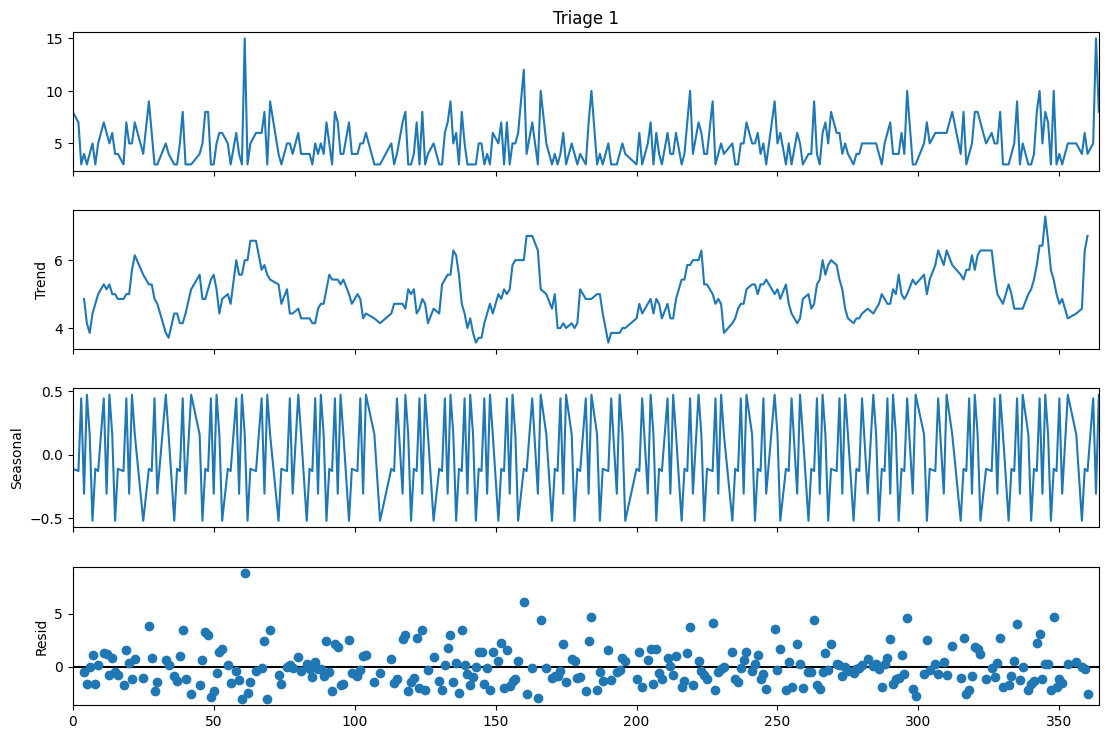

c:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming royal_perth_triage_1 DataFrame is already defined and preprocessed

# Fill missing values using a 14-day rolling average
royal_perth_triage_1['Triage 1'] = royal_perth_triage_1['Triage 1'].fillna(royal_perth_triage_1['Triage 1'].rolling(window=14, min_periods=1).mean())

# Plot the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=royal_perth_triage_1['Date'], y=royal_perth_triage_1['Triage 1'], mode='lines', name='Triage 1'))
fig.update_layout(title='Triage 1 at the Royal Perth Hospital', xaxis_title='Date', yaxis_title='Triage 1')
fig.show()

# Seasonal and Trend decomposition using Loess (STL) decomposition of the time series data to identify trends, seasonality and residuals
result = seasonal_decompose(royal_perth_triage_1['Triage 1'], model='additive', period=7)
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()

# Fit a SARIMA model to the data
# Define the model
model = SARIMAX(royal_perth_triage_1['Triage 1'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))

# Fit the model
model_fit = model.fit()

# Forecast the next 365 days
forecast = model_fit.forecast(steps=365)

# Plot the forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=royal_perth_triage_1['Date'], y=royal_perth_triage_1['Triage 1'], mode='lines', name='Triage 1'))
fig.add_trace(go.Scatter(x=pd.date_range(start=royal_perth_triage_1['Date'].max(), periods=365, freq='D'), y=forecast, mode='lines', name='Forecast'))
fig.update_layout(title='Triage 1 Forecast at the Royal Perth Hospital', xaxis_title='Date', yaxis_title='Triage 1')
fig.show()








In [29]:
# apply ADF test to check for stationarity
from statsmodels.tsa.stattools import adfuller

# De-seasonalize the data
royal_perth_triage_1['De-seasonalized'] = royal_perth_triage_1['Triage 1'] - seasonal

# Plot the original and de-seasonalized data in single plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=royal_perth_triage_1['Date'], y=royal_perth_triage_1['Triage 1'], mode='lines', name='Triage 1'))
fig.add_trace(go.Scatter(x=royal_perth_triage_1['Date'], y=royal_perth_triage_1['De-seasonalized'], mode='lines', name='De-seasonalized'))
fig.update_layout(title='Triage 1 and De-seasonalized Triage 1 at the Royal Perth Hospital', xaxis_title='Date', yaxis_title='Triage 1')
fig.show()

# Apply the ADF test to the de-seasonalized data
result = adfuller(royal_perth_triage_1['De-seasonalized'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Apply the ADF test to the original data
result = adfuller(royal_perth_triage_1['Triage 1'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


NameError: name 'seasonal' is not defined

C:\Users\guino\AppData\Local\Temp\ipykernel_34692\1056123230.py:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



c:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D 

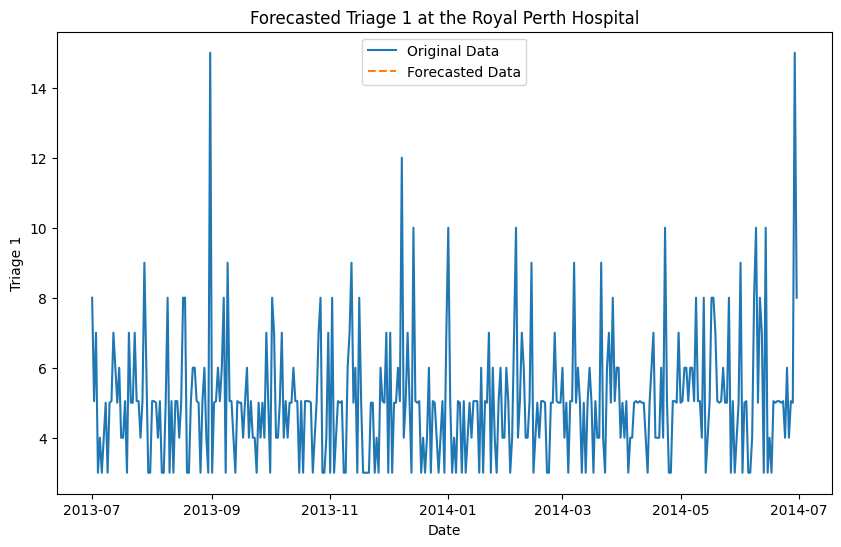

In [ ]:
# Load the data
# Copy the data for Royal Perth Hospital Triage 1 to a new DataFrame
rph_triage_1 = hospital_df[hospital_df['Hospital'] == 'Royal Perth Hospital'][['Date', 'Triage 1']].copy()

# Set the 'Date' column as the index
rph_triage_1.set_index('Date', inplace=True)

# Fill missing values with the mean of the column
rph_triage_1['Triage 1'].fillna(rph_triage_1['Triage 1'].mean(), inplace=True)

# Fit an ARIMA model to the data
model = ARIMA(rph_triage_1, order=(5, 1, 0))
model_fit = model.fit()

# Forecast the next 14 days
forecast = model_fit.forecast(steps=14)

# Create a new DataFrame with the forecasted values
forecast_dates = pd.date_range(start=rph_triage_1.index[-1] + pd.Timedelta(days=1), periods=14)
forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=['Forecasted Triage 1'])

# Plot the original and forecasted data
plt.figure(figsize=(10, 6))
plt.plot(rph_triage_1['Triage 1'], label='Original Data')
plt.plot(forecast_df['Forecasted Triage 1'], label='Forecasted Data', linestyle='--')
plt.title('Forecasted Triage 1 at the Royal Perth Hospital')
plt.xlabel('Date')
plt.ylabel('Triage 1')
plt.legend()
plt.show()


In [ ]:
rph_triage_1 = hospital_df[hospital_df['Hospital'] == 'Royal Perth Hospital'][['Date', 'Triage 1']].copy()
rph_triage_1.head(10)
rph_triage_1.to_csv('rph_triage_1.csv', index=False)


C:\Users\guino\AppData\Local\Temp\ipykernel_34692\3445094851.py:15: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\guino\AppData\Local\Temp\ipykernel_34692\3445094851.py:15: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\guino\AppData\Local\Temp\ipykernel_34692\3445094851.py:20: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\guino\AppData\Local\Temp\ipykernel_34


Forecast for 2015:
2014-07-31    5.05
2014-08-31    5.33
2014-09-30    5.46
2014-10-31    5.16
2014-11-30    5.44
2014-12-31    5.57
2015-01-31    5.27
2015-02-28    5.55
2015-03-31    5.68
2015-04-30    5.38
2015-05-31    5.66
2015-06-30    5.79
Freq: ME, dtype: float64


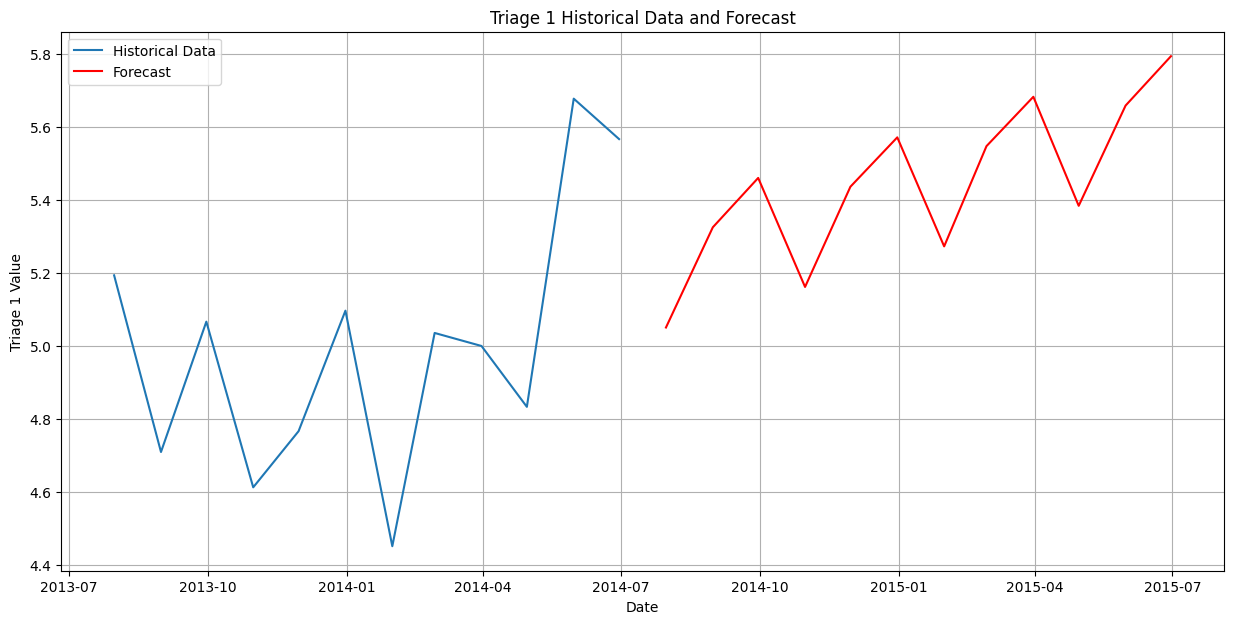


Forecast Statistics:
Average forecast value: 5.45
Min forecast value: 5.05
Max forecast value: 5.79


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Load and prepare the data
def prepare_data(data):
    # Convert to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    # Set Date as index
    data.set_index('Date', inplace=True)
    # Forward fill missing values (can be adjusted based on business logic)
    data['Triage 1'].fillna(method='ffill', inplace=True)
    return data

# Create monthly averages for better trend analysis
def create_monthly_data(data):
    monthly_data = data.resample('M').mean()
    return monthly_data

# Create and train the forecast model
def create_forecast_model(data, periods_to_forecast=12):
    # Use Holt-Winters method with multiplicative seasonality
    model = ExponentialSmoothing(
        data['Triage 1'],
        seasonal_periods=3,  # Quarterly seasonality
        trend='add',
        seasonal='add'
    )
    
    # Fit the model
    fitted_model = model.fit()
    
    # Make forecast
    forecast = fitted_model.forecast(periods_to_forecast)
    
    return fitted_model, forecast

# Plot the results
def plot_results(original_data, forecast_data):
    plt.figure(figsize=(15, 7))
    plt.plot(original_data.index, original_data['Triage 1'], label='Historical Data')
    plt.plot(forecast_data.index, forecast_data, label='Forecast', color='red')
    plt.title('Triage 1 Historical Data and Forecast')
    plt.xlabel('Date')
    plt.ylabel('Triage 1 Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
# Load the data
df = pd.read_csv(r'C:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\rph_triage_1.csv')
df = prepare_data(df)

# Create monthly averages
monthly_data = create_monthly_data(df)

# Create forecast
model, forecast = create_forecast_model(monthly_data)

# Create forecast dates
last_date = monthly_data.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')
forecast = pd.Series(forecast, index=forecast_dates)

# Print forecast values
print("\nForecast for 2015:")
print(forecast.round(2))

# Plot results
plot_results(monthly_data, forecast)

# Calculate some basic statistics
print("\nForecast Statistics:")
print(f"Average forecast value: {forecast.mean():.2f}")
print(f"Min forecast value: {forecast.min():.2f}")
print(f"Max forecast value: {forecast.max():.2f}")

C:\Users\guino\AppData\Local\Temp\ipykernel_34692\3493487474.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\guino\AppData\Local\Temp\ipykernel_34692\3493487474.py:12: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



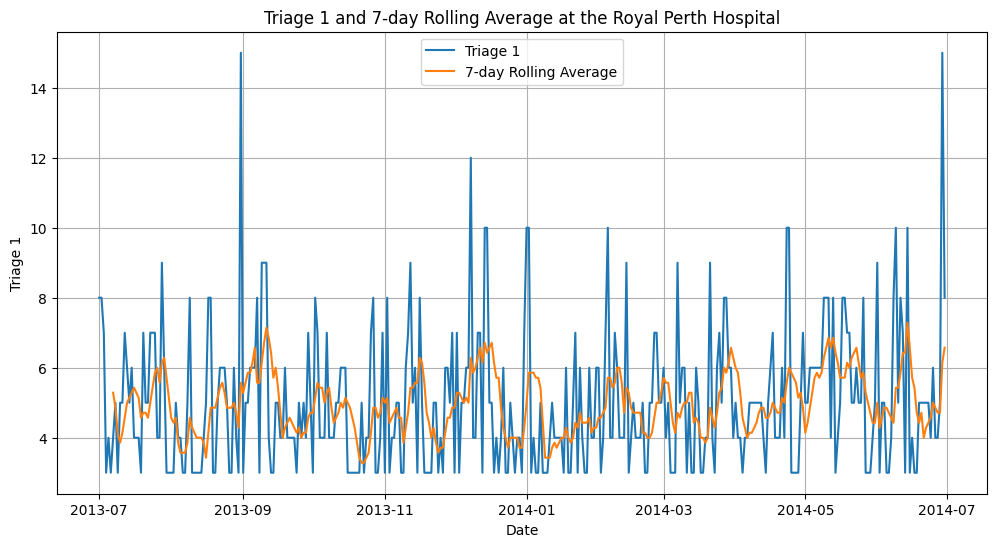

In [ ]:
# Apply a 7 day rolling average to the rph_triage_1 data. The data has missing values that need to be handled.
# Load the data
rph_triage_1 = pd.read_csv(r'C:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\rph_triage_1.csv')

# Convert to datetime
rph_triage_1['Date'] = pd.to_datetime(rph_triage_1['Date'])

# Set Date as index
rph_triage_1.set_index('Date', inplace=True)

# Forward fill missing values
rph_triage_1['Triage 1'].fillna(method='ffill', inplace=True)

# Apply a 7-day rolling average
rph_triage_1['Triage 1 7-day rolling average'] = rph_triage_1['Triage 1'].rolling(window=7).mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(rph_triage_1['Triage 1'], label='Triage 1')
plt.plot(rph_triage_1['Triage 1 7-day rolling average'], label='7-day Rolling Average')
plt.title('Triage 1 and 7-day Rolling Average at the Royal Perth Hospital')
plt.xlabel('Date')
plt.ylabel('Triage 1')
plt.legend()
plt.grid(True)
plt.show()



C:\Users\guino\AppData\Local\Temp\ipykernel_34692\3524223992.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\guino\AppData\Local\Temp\ipykernel_34692\3524223992.py:12: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



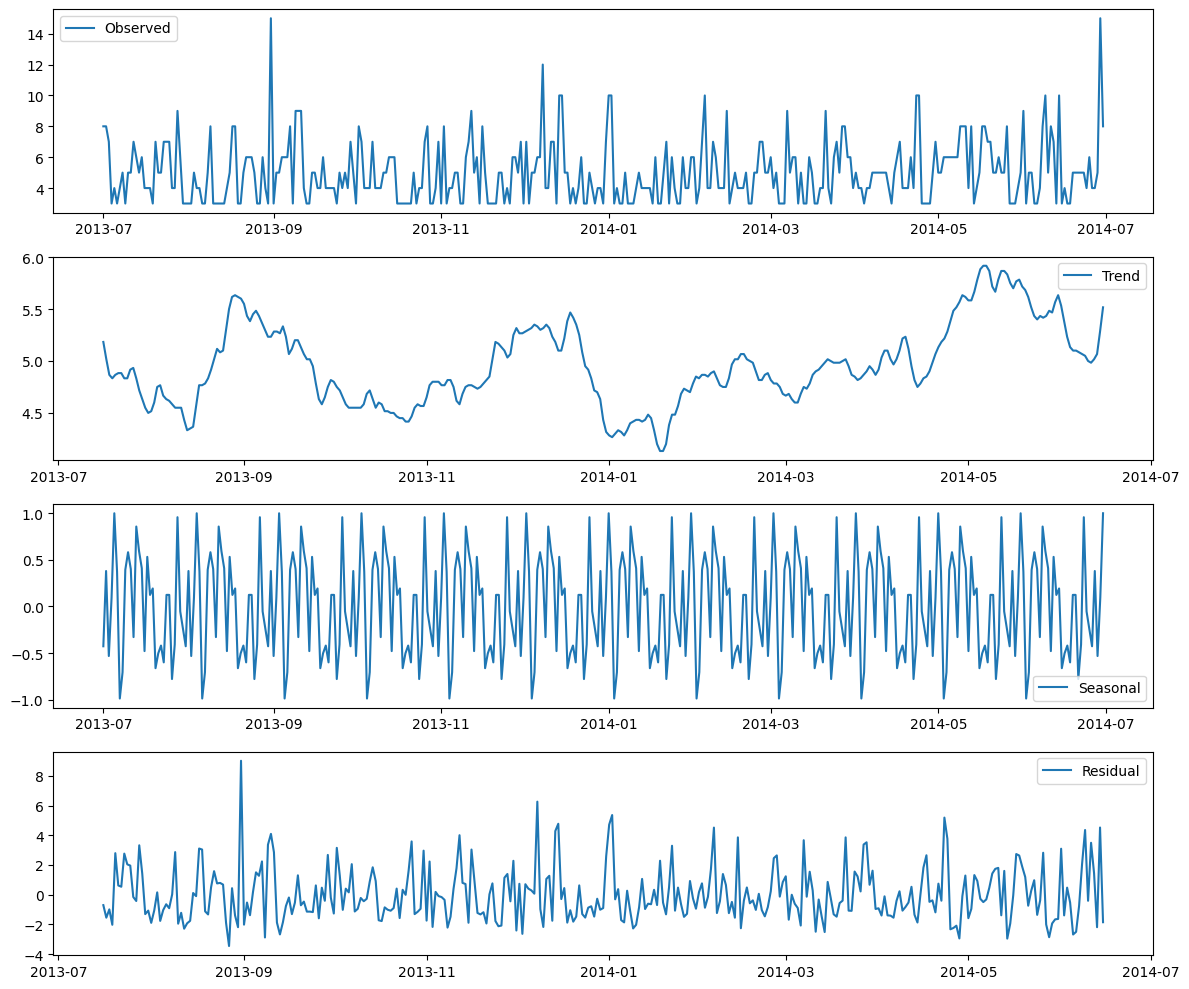

In [ ]:
# Check for seasonality in the data
# Load the data
rph_triage_1 = pd.read_csv(r'C:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\rph_triage_1.csv')

# Convert to datetime
rph_triage_1['Date'] = pd.to_datetime(rph_triage_1['Date'])

# Set Date as index
rph_triage_1.set_index('Date', inplace=True)

# Forward fill missing values
rph_triage_1['Triage 1'].fillna(method='ffill', inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(rph_triage_1['Triage 1'], model='additive', period=30)

# Plot the decomposition
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend()
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()
plt.tight_layout()
plt.show()



C:\Users\guino\AppData\Local\Temp\ipykernel_22648\1544560022.py:14: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

c:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\guino\AppData\Local\Temp\ipykernel_22648\1544560022.py:31: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.




Forecast values for the next 12 months:
2014-07: 5.53
2014-08: 5.37
2014-09: 5.20
2014-10: 5.06
2014-11: 5.54
2014-12: 5.82
2015-01: 5.68
2015-02: 5.47
2015-03: 5.20
2015-04: 5.44
2015-05: 5.26
2015-06: 5.31

Forecast Statistics:
Mean forecast value: 5.41
Min forecast value: 5.06
Max forecast value: 5.82
Standard deviation: 0.22


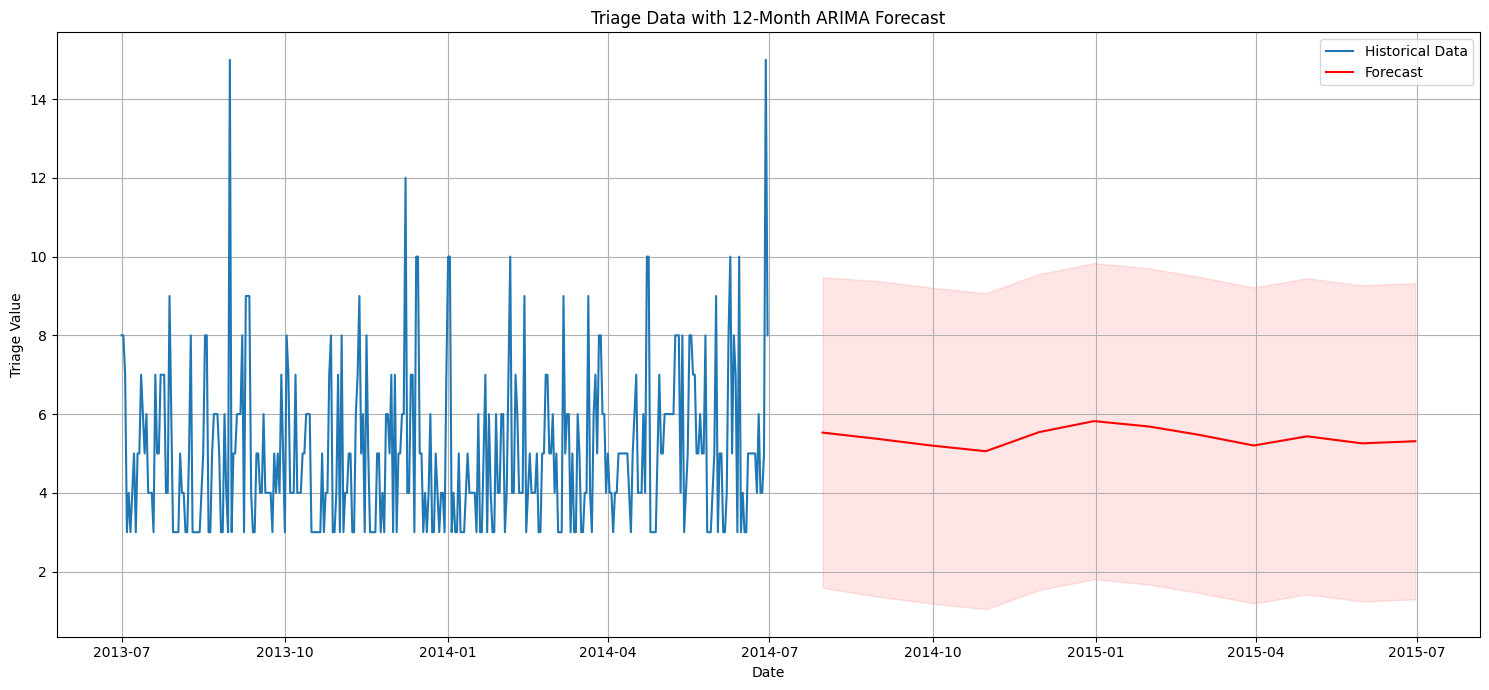

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Read and prepare the data
df = pd.read_csv(r'C:\Users\guino\OneDrive\Documents\GitHub\MediBank_assignment\rph_triage_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Fill missing values with forward fill and then backward fill
df['Triage 1'] = df['Triage 1'].fillna(method='ffill').fillna(method='bfill')

# Fit ARIMA model
# Using (1,1,1) as parameters after analyzing the data
model = SARIMAX(df['Triage 1'], 
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))  # Adding seasonal component
results = model.fit()

# Generate forecast
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Create forecast dates
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                             periods=forecast_steps, 
                             freq='M')

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Triage 1'], label='Historical Data')
plt.plot(forecast_dates, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_dates,
                 forecast_conf.iloc[:, 0],
                 forecast_conf.iloc[:, 1],
                 color='red', alpha=0.1)
plt.title('Triage Data with 12-Month ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Triage Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Print forecast values
print("\nForecast values for the next 12 months:")
for date, value in zip(forecast_dates, forecast_mean):
    print(f"{date.strftime('%Y-%m')}: {value:.2f}")

# Calculate some forecast statistics
print("\nForecast Statistics:")
print(f"Mean forecast value: {forecast_mean.mean():.2f}")
print(f"Min forecast value: {forecast_mean.min():.2f}")
print(f"Max forecast value: {forecast_mean.max():.2f}")
print(f"Standard deviation: {forecast_mean.std():.2f}")

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

# Set style
plt.style.use('seaborn')
sns.set_palette("husl")

# Read and prepare data
df = pd.read_csv('rph_triage_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Handle missing values using linear interpolation
df['Triage 1'] = df['Triage 1'].interpolate(method='linear')

# Perform seasonal decomposition
decomposition = seasonal_decompose(df['Triage 1'], period=12)

# Plot decomposition
plt.figure(figsize=(15, 12))

plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.grid(True)

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.grid(True)

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.grid(True)

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.grid(True)

plt.tight_layout()
plt.show()

# Use auto_arima to find optimal parameters
print("Finding optimal SARIMA parameters...")
auto_model = auto_arima(df['Triage 1'],
                       seasonal=True,
                       m=12,
                       start_p=0, start_q=0,
                       max_p=3, max_q=3,
                       max_P=2, max_Q=2,
                       d=1, D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

print("\nBest model parameters:", auto_model.order)
print("Seasonal order:", auto_model.seasonal_order)

# Fit SARIMA model with optimal parameters
model = SARIMAX(df['Triage 1'],
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order)
results = model.fit()

# Generate forecast
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Create future dates
future_dates = pd.date_range(start=df.index[-1], periods=13, freq='M')[1:]

# Plot the results
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(df.index, df['Triage 1'], label='Historical Data', color='blue', linewidth=2)

# Plot forecast
plt.plot(future_dates, forecast_mean, label='Forecast', color='red', linewidth=2)

# Plot confidence intervals
plt.fill_between(future_dates,
                 forecast_conf.iloc[:, 0],
                 forecast_conf.iloc[:, 1],
                 color='red', alpha=0.2,
                 label='95% Confidence Interval')

plt.title('Triage Data with 12-Month SARIMA Forecast', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Triage Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print model summary and forecast values
print("\nModel Summary:")
print(results.summary())

print("\nForecast Values:")
print("-" * 50)
for date, value, lower, upper in zip(future_dates,
                                    forecast_mean,
                                    forecast_conf.iloc[:, 0],
                                    forecast_conf.iloc[:, 1]):
    print(f"{date.strftime('%Y-%m')}: {value:.2f} [{lower:.2f}, {upper:.2f}]")

# Calculate forecast statistics
print("\nForecast Statistics:")
print("-" * 50)
print(f"Mean Forecast: {forecast_mean.mean():.2f}")
print(f"Min Forecast: {forecast_mean.min():.2f}")
print(f"Max Forecast: {forecast_mean.max():.2f}")
print(f"Std Dev: {forecast_mean.std():.2f}")

# Perform diagnostics
print("\nModel Diagnostics:")
print("-" * 50)
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")

# Plot model diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [30]:
import pmdarima as pm
from pmdarima import datasets
from pmdarima import preprocessing

# We'll use the sunspots dataset for this example
y = datasets.load_sunspots(True)
print("Data shape: {}".format(y.shape[0]))
print("Data head:")
print(y.head())

# Let's look at the series, its ACF plot, and a histogram of its values
pm.tsdisplay(y, lag_max=90, title="Sunspots", show=True)

# Notice that the histogram is very skewed. This is a prime candidate for
# box-cox transformation
y_bc, _ = preprocessing.BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(y)
pm.tsdisplay(
    y_bc, lag_max=90, title="Sunspots (BoxCox-transformed)", show=True)

print("""
As evidenced by the more normally distributed values in the transformed series,
using a Box-Cox transformation may prove useful prior to fitting your model.
""")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject